In [1]:
import sys, os
sys.path.insert(0, '../..')
# os.environ["CUDA_VISIBLE_DEVICES"]=""

os.environ['disable_tqdm'] = 'true'

In [2]:
import numpy as np
import pandas as pd
import torch
from models.weighted_node2vec import WeightedNode2Vec
from dataset import triplet_dataset, pokec_data
from utils.config import DEVICE
import gc
from tqdm import trange
from utils.link_prediction import GCNLinkPrediction
import residual2vec as rv
import warnings
import faiss
import matplotlib.pyplot as plt
from utils.score import statistical_parity
from utils import graph_utils
from utils.snakemake_utils import FileResources
import seaborn as sns
from utils import snakemake_utils
import pickle as pkl
warnings.filterwarnings("ignore")
gc.enable()

/data/sg/ashutiwa/miniconda3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
! ls /data/sg/ashutiwa/final_crosswalk_temp/airport/airport_one/

airport_adj_crosswalk.npz
airport_adj_fairwalk.npz
airport_adj.npz
airport_crosswalk_deepwalk.npy
airport_crosswalk_node2vec.npy
airport_deepwalk_128_embs.npy
airport_deepwalk.npy
airport_fairwalk_deepwalk.npy
airport_fairwalk_node2vec.npy
airport_gat_None_deepwalk_deepwalk_embs.npy
airport_gat_None_deepwalk_deepwalk.h5
airport_gat_None_deepwalk_r2v_embs.npy
airport_gat_None_deepwalk_r2v.h5
airport_gat_None_node2vec_deepwalk_embs.npy
airport_gat_None_node2vec_deepwalk.h5
airport_gat_None_node2vec_r2v_embs.npy
airport_gat_None_node2vec_r2v.h5
airport_gcn_None_deepwalk_deepwalk_embs.npy
airport_gcn_None_deepwalk_deepwalk.h5
airport_gcn_None_deepwalk_r2v_embs.npy
airport_gcn_None_deepwalk_r2v.h5
airport_gcn_None_node2vec_deepwalk_embs.npy
airport_gcn_None_node2vec_deepwalk.h5
airport_gcn_None_node2vec_r2v_embs.npy
airport_gcn_None_node2vec_r2v.h5
airport_node2vec_128_embs.npy
airport_node2vec.npy
airport_residual2vec_128_embs.npy
airport_test_adj.npz


In [4]:
y = snakemake_utils.get_dataset("polblog").get_grouped_col()
sp_score, roc_score, gini_score, embs = {}, {}, {}, {}
DATA_ROOT = '/data/sg/ashutiwa/final_crosswalk_temp/polblog/'

DIRS = ['polblog_one/', 'polblog_two/', 'polblog_three/', 'polblog_four/', 'polblog_five/']
DATASET = 'polblog'
model_to_embs = {
    "fairwalk+deepwalk": "_fairwalk_deepwalk.npy",
    "fairwalk+node2vec": "_fairwalk_node2vec.npy",
    "crosswalk+deepwalk": "_crosswalk_deepwalk.npy",
    "crosswalk+node2vec": "_crosswalk_node2vec.npy",
    "GCN+deepwalk+random": "_gcn_None_deepwalk_deepwalk_embs.npy",
    "GCN+deepwalk+r2v": "_gcn_None_deepwalk_r2v_embs.npy",
    "GCN+node2vec+random": "_gcn_None_node2vec_deepwalk_embs.npy",
    "GCN+node2vec+r2v": "_gcn_None_node2vec_r2v_embs.npy",
    "GAT+deepwalk+random": "_gat_None_deepwalk_deepwalk_embs.npy",
    "GAT+deepwalk+r2v": "_gat_None_deepwalk_r2v_embs.npy",
    "GAT+node2vec+random": "_gat_None_node2vec_deepwalk_embs.npy",
    "GAT+node2vec+r2v": "_gat_None_node2vec_r2v_embs.npy",
    "deepwalk": "_deepwalk_128_embs.npy",
    "node2vec": "_node2vec_128_embs.npy",
    "residual2vec": "_residual2vec_128_embs.npy"
    
    
}
M = list(model_to_embs.keys())


TEST_ADJ_FILE='/data/sg/ashutiwa/final_crosswalk_temp/polblog/polblog_one/polblog_test_adj.npz'
NUM_NODES=1224
k=5

# distributions of positive and negative edgeswith dot product

In [5]:
def get_roc_score(df):
    from sklearn.metrics import roc_auc_score
    y_pred = np.concatenate((df.positive_dot.values, df.negative_dot.values))
    y_true = np.concatenate((np.ones_like(df.positive_dot.values), np.zeros_like(df.negative_dot.values)))
    return roc_auc_score(y_true, y_pred)



In [6]:
def plot_dot_(df, title):
#     df = pd.DataFrame({
#         "positive_dot": np.array([np.dot(a[i], p[i]) for i in trange(a.shape[0])]),
#         "negative_dot": np.array([np.dot(a[i], n[i]) for i in trange(a.shape[0])])
#     })
    
#     fig, ax = plt.subplots(1,1)
    df.positive_dot.plot(kind='density', title=title)
    df.negative_dot.plot(kind='density', title=title)
#     ax.set_xlim(-1000, 1000)
    ax.legend(['positive_neighbors', 'negative_neighbors'])
#     fig.show()

In [7]:
FILE_CACHE = {}
def create_dot_df(A, file=TEST_ADJ_FILE):
    """
    A are node embeddings of shape # nodes \times 128
    """
    EDGE_IDX = snakemake_utils.get_edge_index_from_sparse_path(file)
    if file in FILE_CACHE:
        NEGATIVE_EDGE_IDX, EDGE_IDX = FILE_CACHE[file]
    else:
        NEGATIVE_EDGE_IDX, EDGE_IDX = graph_utils._negative_sampling_sparse(edge_index=EDGE_IDX, n_nodes=NUM_NODES, return_pos_samples=True)
        FILE_CACHE[file] = (NEGATIVE_EDGE_IDX, EDGE_IDX)
    print("selected edge_idx size: {}".format(EDGE_IDX.size(1)))

    positive_dot = np.sum(A[EDGE_IDX[0,:]] * A[EDGE_IDX[1,:]], axis=1)
    negative_dot = np.sum(A[NEGATIVE_EDGE_IDX[0,:]] * A[NEGATIVE_EDGE_IDX[1,:]], axis=1)
    dot = pd.DataFrame()
    dot["positive_dot"] = positive_dot
    dot["negative_dot"] = negative_dot
    
    return dot

# residual2vec

In [8]:
model = "residual2vec"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12168


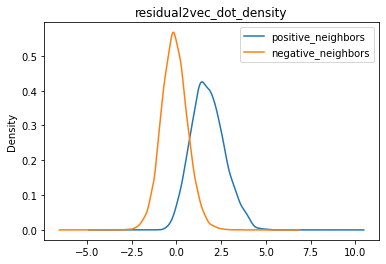

In [9]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [10]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4770.88it/s]


((6120, 2), 0.003057173710569349, 0.9474822792379405, 0.22732215122146116)

# deepwalk

In [11]:
model = "deepwalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12168


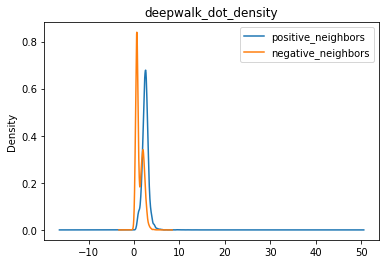

In [12]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [13]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4101.52it/s]


((6112, 2), 0.0049704216145188, 0.8823852515581769, 0.2992830588393812)

# node2vec

In [14]:
model = "node2vec"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12168


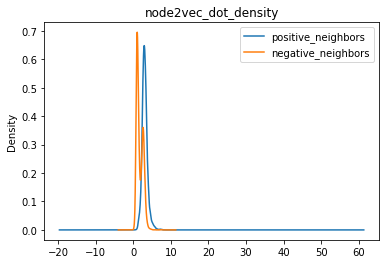

In [15]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [16]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4117.69it/s]


((6120, 2), 0.004753600132372768, 0.87423327145581, 0.29447596645556)

# fairwalk+deepwalk

In [17]:
model = "fairwalk+deepwalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12168


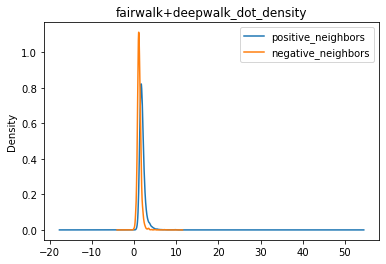

In [18]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [19]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4801.68it/s]


((6120, 2), 0.0036058151860391308, 0.8576972165056295, 0.23257894173568885)

# fairwalk+node2vec

In [20]:
model = "fairwalk+node2vec"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape


(1224, 128)

selected edge_idx size: 12168


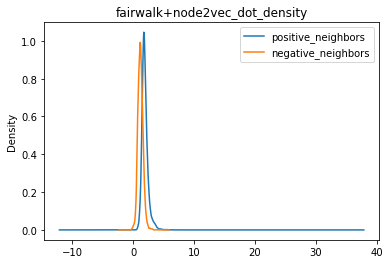

In [21]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [22]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4619.19it/s]


((6114, 2), 0.003873493681312359, 0.8881872757399043, 0.2527419848517553)

# crosswalk+deepwalk

In [23]:
model = "crosswalk+deepwalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12168


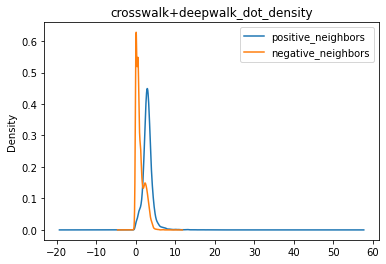

In [24]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [25]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 3740.97it/s]


((6120, 2), 0.004393152187129349, 0.8804069822290691, 0.295556379882056)

# crosswalk+node2vec

In [26]:
model = "crosswalk+node2vec"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12168


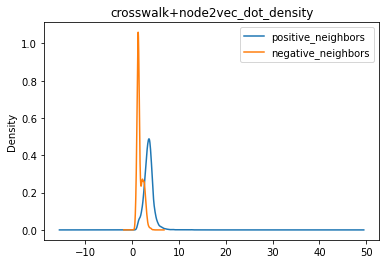

In [27]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [28]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4064.18it/s]


((6106, 2), 0.004669198457910078, 0.9443993952082633, 0.30171929270722736)

# GCN+deepwalk+random

In [29]:
model = "GCN+deepwalk+random"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12168


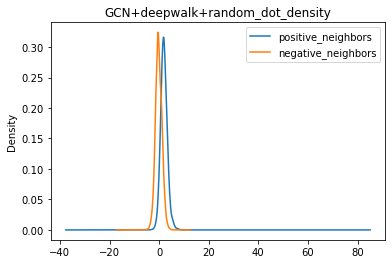

In [30]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [31]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4965.41it/s]


((6120, 2), 0.004316210165650983, 0.8740000116439104, 0.2917917313596407)

# GCN+deepwalk+r2v

In [32]:
model = "GCN+deepwalk+r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape


(1224, 128)

selected edge_idx size: 12168


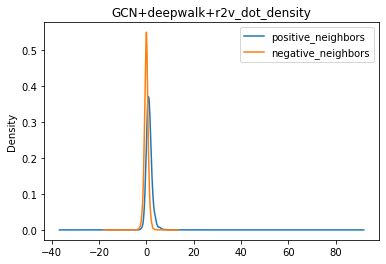

In [33]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [34]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4279.62it/s]


((6120, 2), 0.0032425607039378514, 0.8010170206145305, 0.23369863227809667)

# GCN+node2vec+random

In [35]:
model = "GCN+node2vec+random"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12168


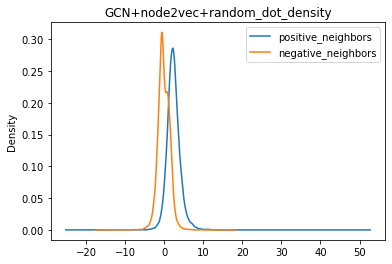

In [36]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [37]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 5051.08it/s]


((6120, 2), 0.0045480747503154955, 0.8810567482323949, 0.30149940423832444)

# GCN+node2vec+r2v

In [38]:
model = "GCN+node2vec+r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12168


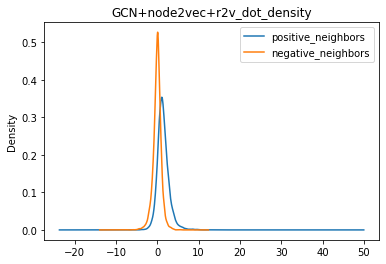

In [39]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [40]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4959.34it/s]


((6120, 2), 0.0035826095583556716, 0.8167263309016741, 0.2527285579155391)

# GAT+deepwalk+random

In [41]:
model = "GAT+deepwalk+random"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12168


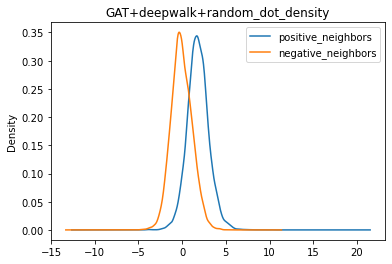

In [42]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [43]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 3646.55it/s]


((6120, 2), 0.0043206505198600306, 0.8651345887468063, 0.2962446250651476)

# GAT+deepwalk+r2v

In [44]:
model = "GAT+deepwalk+r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12168


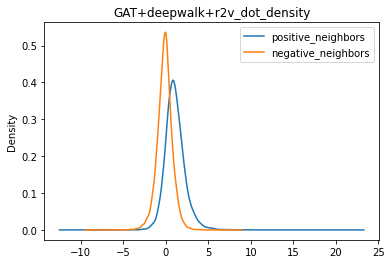

In [45]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [46]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 3875.73it/s]


((6120, 2), 0.0030733086887235568, 0.8102947858568685, 0.22686142145489444)

# GAT+node2vec+random

In [47]:
model = "GAT+node2vec+random"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12168


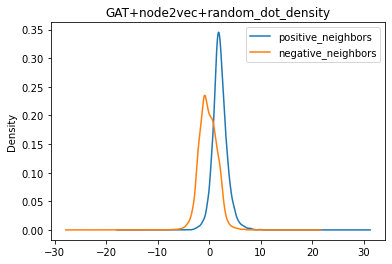

In [48]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [49]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4953.58it/s]


((6120, 2), 0.00458915635135109, 0.8504228927817913, 0.3045781205489113)

# GAT+node2vec+r2v

In [50]:
model = "GAT+node2vec+r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + model_to_embs[model])
A = embs[model]
A.shape

(1224, 128)

selected edge_idx size: 12168


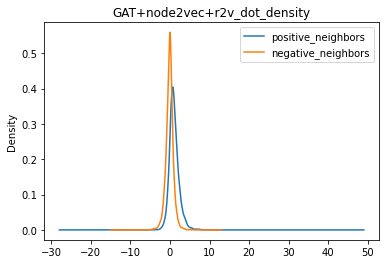

In [51]:
# plot density
dot = create_dot_df(A)
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [52]:
# # create edge_list
batch_size = 20

edges = snakemake_utils.return_new_graph(A, k, batch_size)
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4290.24it/s]


((6120, 2), 0.0035586575397504212, 0.7874863879714245, 0.2582570607869165)

# plot statistical parity scores

# gini sp scores

residual2vec 0.22732215122146116
deepwalk 0.2992830588393812
node2vec 0.29447596645556
fairwalk+deepwalk 0.23257894173568885
fairwalk+node2vec 0.2527419848517553
crosswalk+deepwalk 0.295556379882056
crosswalk+node2vec 0.30171929270722736
GCN+deepwalk+random 0.2917917313596407
GCN+deepwalk+r2v 0.23369863227809667
GCN+node2vec+random 0.30149940423832444
GCN+node2vec+r2v 0.2527285579155391
GAT+deepwalk+random 0.2962446250651476
GAT+deepwalk+r2v 0.22686142145489444
GAT+node2vec+random 0.3045781205489113
GAT+node2vec+r2v 0.2582570607869165


Text(0.5, 1.0, 'gini statistical parity scores')

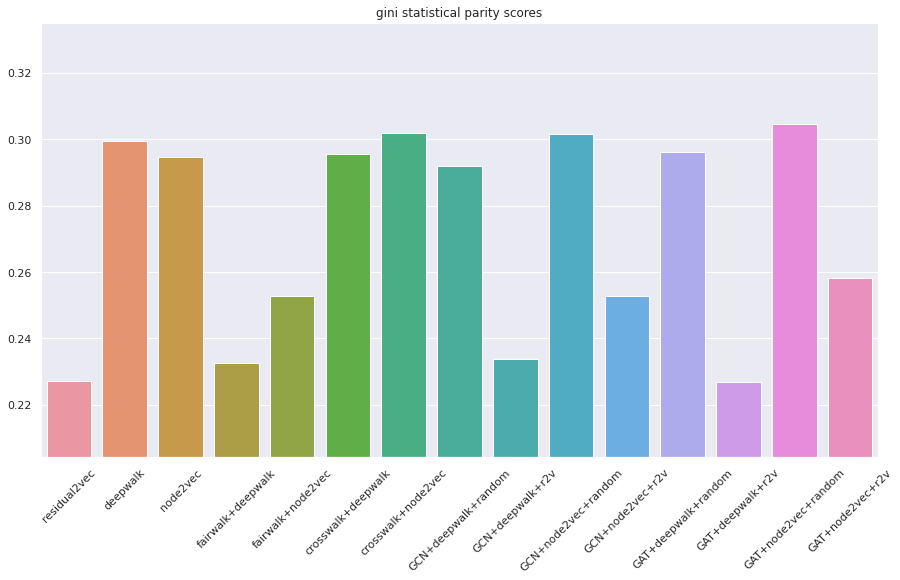

In [53]:

for i, j in gini_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
ax.set_ylim(min(gini_score.values()) * .9 , max(gini_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("gini statistical parity scores")

# sp scores

residual2vec 0.003057173710569349
deepwalk 0.0049704216145188
node2vec 0.004753600132372768
fairwalk+deepwalk 0.0036058151860391308
fairwalk+node2vec 0.003873493681312359
crosswalk+deepwalk 0.004393152187129349
crosswalk+node2vec 0.004669198457910078
GCN+deepwalk+random 0.004316210165650983
GCN+deepwalk+r2v 0.0032425607039378514
GCN+node2vec+random 0.0045480747503154955
GCN+node2vec+r2v 0.0035826095583556716
GAT+deepwalk+random 0.0043206505198600306
GAT+deepwalk+r2v 0.0030733086887235568
GAT+node2vec+random 0.00458915635135109
GAT+node2vec+r2v 0.0035586575397504212


Text(0.5, 1.0, 'statistical parity scores')

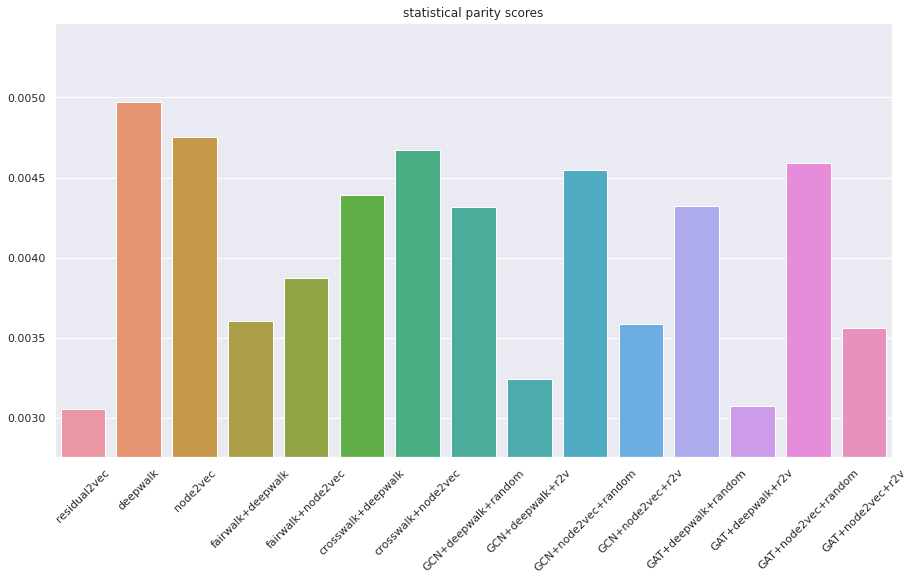

In [54]:

for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_ylim(min(sp_score.values()) * .9, max(sp_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("statistical parity scores")

# roc auc scores

residual2vec 0.9474822792379405
deepwalk 0.8823852515581769
node2vec 0.87423327145581
fairwalk+deepwalk 0.8576972165056295
fairwalk+node2vec 0.8881872757399043
crosswalk+deepwalk 0.8804069822290691
crosswalk+node2vec 0.9443993952082633
GCN+deepwalk+random 0.8740000116439104
GCN+deepwalk+r2v 0.8010170206145305
GCN+node2vec+random 0.8810567482323949
GCN+node2vec+r2v 0.8167263309016741
GAT+deepwalk+random 0.8651345887468063
GAT+deepwalk+r2v 0.8102947858568685
GAT+node2vec+random 0.8504228927817913
GAT+node2vec+r2v 0.7874863879714245


Text(0.5, 1.0, 'roc scores')

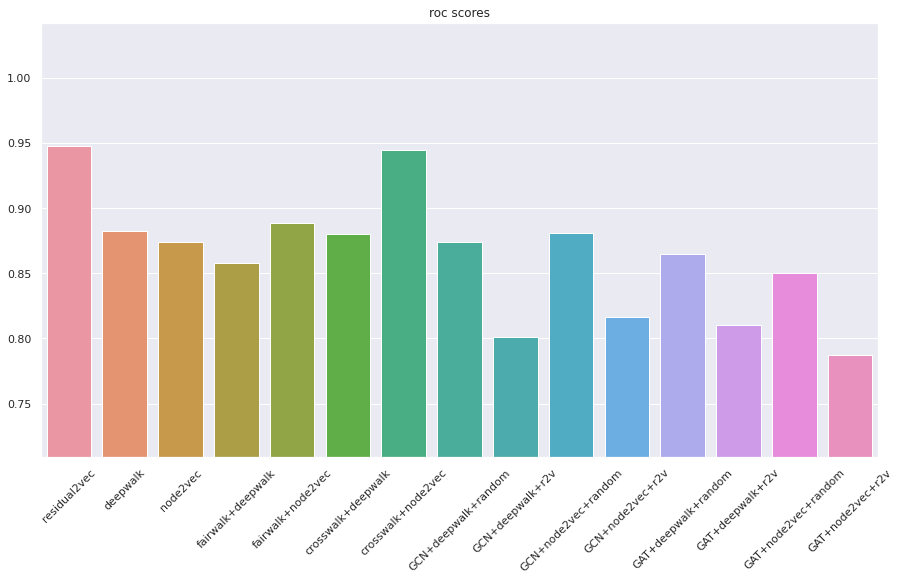

In [55]:

for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_ylim(min(roc_score.values()) * .9, max(roc_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("roc scores")

In [56]:

N = 20

sp_scores, gini_scores = np.zeros((N, len(M))), np.zeros((N, len(M)))
for k in range(N):
    for idx, m in enumerate(M):
        if k == 0: continue
        batch_size =  2000
        A = embs[m]
        batch_size = 20

        edges = snakemake_utils.return_new_graph(A, k, batch_size)
        
    
        gini_scores[k, idx] = statistical_parity(edges, y, metric='gini')
        sp_scores[k, idx] = statistical_parity(edges, y, )


WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4934.76it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 5105.41it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4689.90it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4726.37it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 5462.62it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████

100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4416.58it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4221.01it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4890.05it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 5068.09it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 5119.71it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 5043.91it/s]
WARNING clustering 1224 points to 35 centroids: please 

100%|████████████████████████████████████████| 61/61 [00:00<00:00, 5230.45it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 5055.97it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4426.36it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4636.52it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4914.95it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4955.02it/s]
WARNING clustering 1224 points to 35 centroids: please 

100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4902.61it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4208.03it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4990.20it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4319.72it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4873.20it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4897.17it/s]
WARNING clustering 1224 points to 35 centroids: please 

100%|████████████████████████████████████████| 61/61 [00:00<00:00, 5048.19it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4852.03it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4922.80it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4647.81it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4569.53it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4288.08it/s]
WARNING clustering 1224 points to 35 centroids: please 

100%|████████████████████████████████████████| 61/61 [00:00<00:00, 5002.98it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4772.03it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4637.28it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 3243.40it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4994.39it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4311.27it/s]
WARNING clustering 1224 points to 35 centroids: please 

100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4146.58it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 2676.25it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4344.66it/s]


Text(0.5, 1.0, 'gini scores vs # nn')

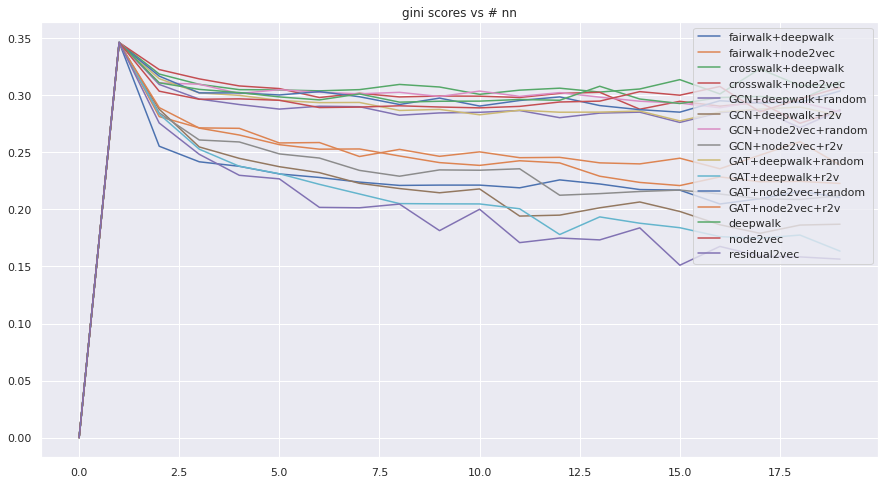

In [57]:
for i in range(len(M)):
    plt.plot(gini_scores[:, i], label=M[i])
plt.legend(loc="upper right")
plt.title("gini scores vs # nn")

Text(0.5, 1.0, 'sp scores vs # nn')

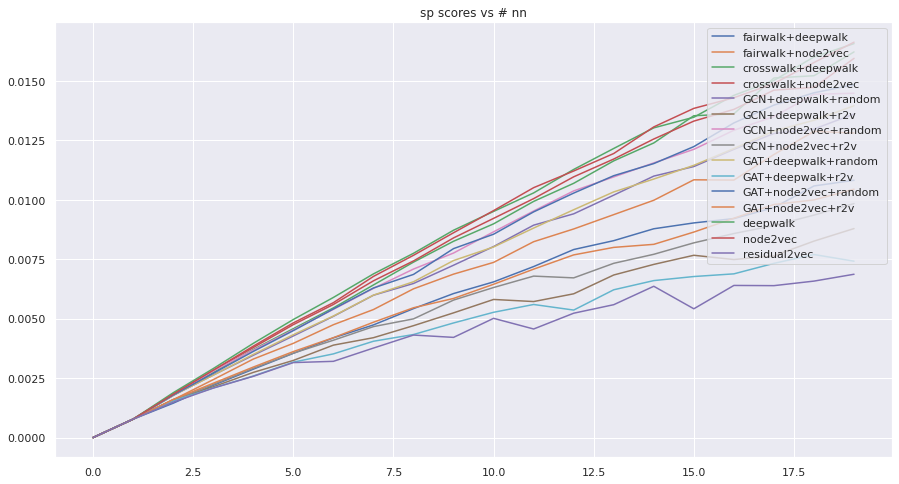

In [58]:
for i in range(len(M)):
    plt.plot(sp_scores[:, i], label=M[i])
plt.legend(loc="upper right")

plt.title("sp scores vs # nn")

# combine all different runs

In [59]:

def roc_scores(model_name):
    scores = np.zeros(len(DIRS))
    for idx, d in enumerate(DIRS):
        A = np.load(DATA_ROOT + d + DATASET + model_to_embs[model_name])
        file = DATA_ROOT + d + DATASET + '_test_adj.npz'
        dot = create_dot_df(A, file)
        scores[idx] = get_roc_score(dot)
    return scores


def statisticalp_scores(model_name, K=5):
    scores, scores_gini = np.zeros(len(DIRS)), np.zeros(len(DIRS))
    for idx, d in enumerate(DIRS):
        A = np.load(DATA_ROOT + d + DATASET + model_to_embs[model_name])
        batch_size = 20

        edges = snakemake_utils.return_new_graph(A, K, batch_size)
        scores_gini[idx] = statistical_parity(edges, y, metric='gini')
        
        scores[idx] = statistical_parity(edges, y, )
    return scores, scores_gini

selected edge_idx size: 12168
selected edge_idx size: 13123
selected edge_idx size: 12153
selected edge_idx size: 12926
selected edge_idx size: 13028
selected edge_idx size: 12168
selected edge_idx size: 13123
selected edge_idx size: 12153
selected edge_idx size: 12926
selected edge_idx size: 13028
selected edge_idx size: 12168
selected edge_idx size: 13123
selected edge_idx size: 12153
selected edge_idx size: 12926
selected edge_idx size: 13028
selected edge_idx size: 12168
selected edge_idx size: 13123
selected edge_idx size: 12153
selected edge_idx size: 12926
selected edge_idx size: 13028
selected edge_idx size: 12168
selected edge_idx size: 13123
selected edge_idx size: 12153
selected edge_idx size: 12926
selected edge_idx size: 13028
selected edge_idx size: 12168
selected edge_idx size: 13123
selected edge_idx size: 12153
selected edge_idx size: 12926
selected edge_idx size: 13028
selected edge_idx size: 12168
selected edge_idx size: 13123
selected edge_idx size: 12153
selected e

Text(0.5, 1.0, 'roc scores')

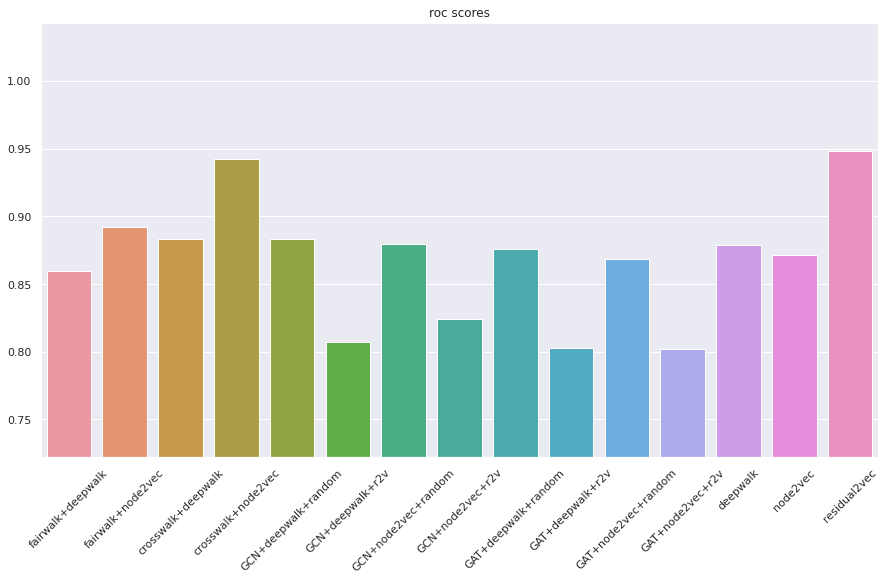

In [60]:

roc_score = {m: np.mean(roc_scores(m)) for m in model_to_embs}

for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_ylim(min(roc_score.values()) * .9, max(roc_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("roc scores")

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4575.66it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4175.07it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 3357.73it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 3896.15it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4878.96it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████

100%|████████████████████████████████████████| 61/61 [00:00<00:00, 6114.44it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4204.71it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 5152.50it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 5107.55it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 5072.82it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 5103.27it/s]
WARNING clustering 1224 points to 35 centroids: please 

fairwalk+deepwalk 0.0037143622261317233
fairwalk+node2vec 0.0039788335511003765
crosswalk+deepwalk 0.004684156320649235
crosswalk+node2vec 0.0047074300668843065
GCN+deepwalk+random 0.004390596172721028
GCN+deepwalk+r2v 0.003239125086570981
GCN+node2vec+random 0.004485376575399433
GCN+node2vec+r2v 0.0036685263848712964
GAT+deepwalk+random 0.004442432131237228
GAT+deepwalk+r2v 0.0030092021066760546
GAT+node2vec+random 0.004498298977544601
GAT+node2vec+r2v 0.0036239600246827696
deepwalk 0.004946712333734534
node2vec 0.00487755972928137
residual2vec 0.0030569774684460226


Text(0.5, 1.0, 'statistical parity scores')

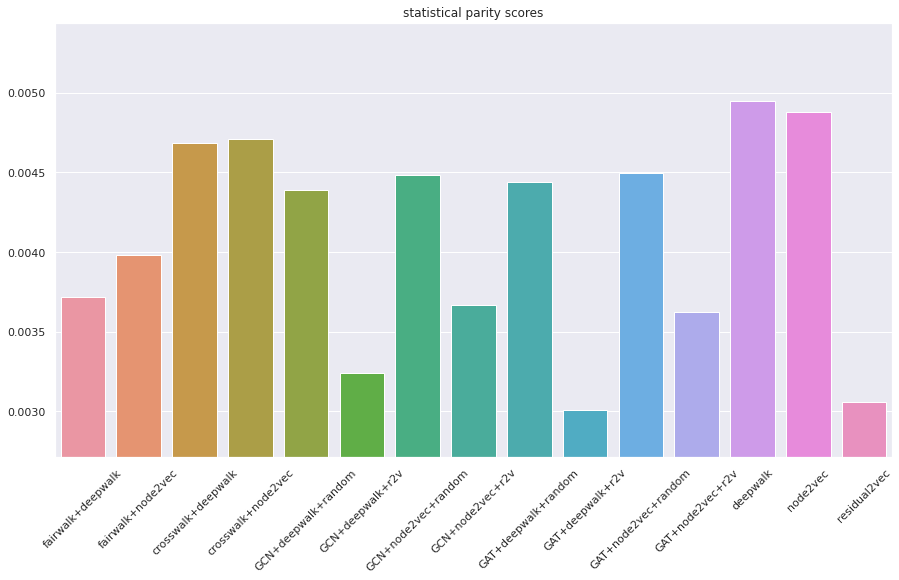

In [61]:

temp = {m: statisticalp_scores(m) for m in model_to_embs}

sp_score = {m: np.mean(v[0]) for m,v in temp.items()}
for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_ylim(min(sp_score.values()) * .9, max(sp_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("statistical parity scores")

fairwalk+deepwalk 0.24384791156671626
fairwalk+node2vec 0.26088729398279364
crosswalk+deepwalk 0.31062940013638346
crosswalk+node2vec 0.3045806249343623
GCN+deepwalk+random 0.29915159546524395
GCN+deepwalk+r2v 0.2333290330188683
GCN+node2vec+random 0.2995099806624367
GCN+node2vec+r2v 0.25341926542899085
GAT+deepwalk+random 0.3026875659854463
GAT+deepwalk+r2v 0.22404619989245375
GAT+node2vec+random 0.3006334197764528
GAT+node2vec+r2v 0.25662538883546404
deepwalk 0.29890090674586245
node2vec 0.29734356471992457
residual2vec 0.2220256769942163


Text(0.5, 1.0, 'gini statistical parity scores')

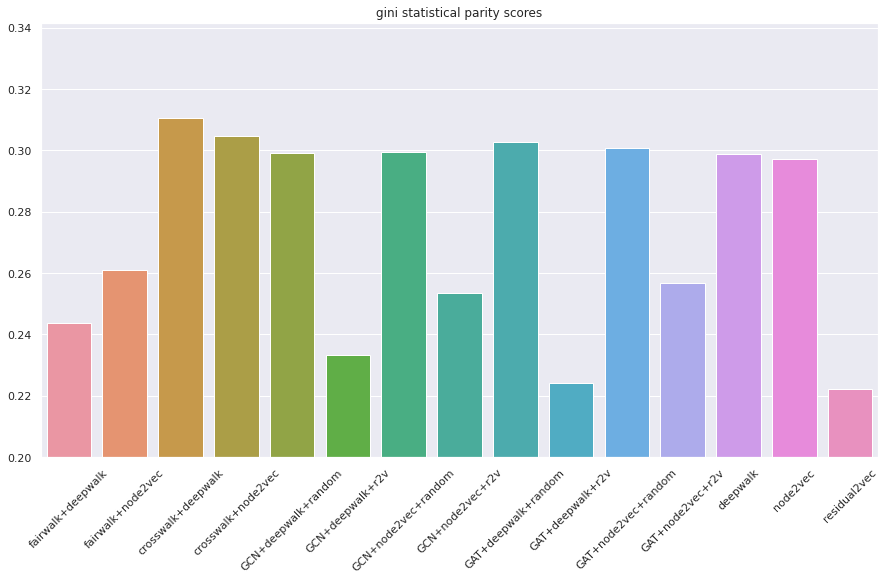

In [62]:
gini_score = {m: np.mean(v[1]) for m,v in temp.items()}
for i, j in gini_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
ax.set_ylim(min(gini_score.values()) * .9, max(gini_score.values()) * 1.1)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("gini statistical parity scores")

In [63]:

# roc_score, sp_score, gini_score= {}, {}, {}
roc_score = {m: roc_scores(m) for m in model_to_embs}
temp = {m: statisticalp_scores(m) for m in model_to_embs}
sp_score = {m: v[0] for m,v in temp.items()}
gini_score = {m: v[1] for m,v in temp.items()}
pkl.dump(roc_score, open(DATA_ROOT + "roc_score.pkl", 'wb'))

pkl.dump(sp_score, open(DATA_ROOT + "sp_score.pkl", 'wb'))

pkl.dump(gini_score, open(DATA_ROOT + "gini_score.pkl", 'wb'))

selected edge_idx size: 12168
selected edge_idx size: 13123
selected edge_idx size: 12153
selected edge_idx size: 12926
selected edge_idx size: 13028
selected edge_idx size: 12168
selected edge_idx size: 13123
selected edge_idx size: 12153
selected edge_idx size: 12926
selected edge_idx size: 13028
selected edge_idx size: 12168
selected edge_idx size: 13123
selected edge_idx size: 12153
selected edge_idx size: 12926
selected edge_idx size: 13028
selected edge_idx size: 12168
selected edge_idx size: 13123
selected edge_idx size: 12153
selected edge_idx size: 12926
selected edge_idx size: 13028
selected edge_idx size: 12168
selected edge_idx size: 13123
selected edge_idx size: 12153
selected edge_idx size: 12926
selected edge_idx size: 13028
selected edge_idx size: 12168
selected edge_idx size: 13123
selected edge_idx size: 12153
selected edge_idx size: 12926
selected edge_idx size: 13028
selected edge_idx size: 12168
selected edge_idx size: 13123
selected edge_idx size: 12153
selected e

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4843.03it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4741.17it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4765.19it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4929.72it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4870.04it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|█████████████████████████████████████

100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4008.53it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 4954.73it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 5228.10it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 5170.62it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 5096.97it/s]
WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points
100%|████████████████████████████████████████| 61/61 [00:00<00:00, 5014.95it/s]
WARNING clustering 1224 points to 35 centroids: please 